In [1]:
import os, json
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from libcbmwrapper import LibCBMWrapper
import libcbmconfig
import cbm_defaults

In [3]:
dllpath = r'C:\dev\LibCBM\LibCBM\x64\Debug\LibCBM.dll'
dlldir = os.path.dirname(dllpath)
cwd = os.getcwd()
os.chdir(dlldir)
dll = LibCBMWrapper(dllpath)
os.chdir(cwd)

In [4]:

dbpath = 'C:\dev\cbm_defaults\cbm_defaults.db'

#create a single classifier/classifier value for the single growth curve
classifiers_config = libcbmconfig.classifier_config([
    libcbmconfig.classifier("growth_curve", [
        libcbmconfig.classifier_value("growth_curve1")
    ])
])


transitions_config = []
species_reference = cbm_defaults.load_species_reference(dbpath, "en-CA")

merch_volume_to_biomass_config = libcbmconfig.merch_volume_to_biomass_config(
    dbpath, [
        libcbmconfig.merch_volume_curve(
            classifier_set = ['growth_curve1'], 
            softwood_species_id = species_reference["Spruce"]["species_id"], 
            softwood_age_volume_pairs=[
                    (0, 0.0),
                    (10, 10.0),
                    (20, 15.0),
                    (30, 20.0),
                    (40, 25.0),
                    (50, 30.0),
                    (60, 35.0),
                    (70, 40.0),
                    (80, 45.0),
                    (90, 50.0),
                    (100, 55.0),
                    (110, 60.0),
                    (120, 65.0),
                    (130, 70.0),
                    (140, 75.0),
                    (150, 80.0),
                    (160, 85.625),
                    (170, 90.73529412),
                    (180, 95.84558824),
                    (190, 100.9558824)],
            hardwood_species_id=None,
            hardwood_age_volume_pairs=None)
    ]) 



In [5]:
config = libcbmconfig.initialize_config(
    dbpath = dbpath,
    merch_volume_to_biomass = merch_volume_to_biomass_config,
    classifiers = classifiers_config,
    transitions = transitions_config,
    save_path = "config.json")


In [6]:
dll.Initialize(libcbmconfig.to_string(config))

## Set up the simulation variables  ##


In [7]:
nstands = 1
age = np.array([0],dtype=np.int32)
classifiers = np.array([1], dtype=np.int32)
spatial_units = np.array([42],dtype=np.int32)
pools = np.zeros((1,len(config["pools"])))
pools[:,0] = 1.0


### Run the simulation for several iterations ###
This includes:
 1. computing the merchantable growth operation matrix 
 2. applying the growth operation matrix to the pools
 3. save the result to a pandas dataframe
 4. increment the age
 

In [8]:

op = dll.AllocateOp(nstands)

result = pd.DataFrame()
for i in range(0, 200):
    dll.GetMerchVolumeGrowthOps(
        op, 
        classifiers=classifiers,
        pools=pools,
        ages=age,
        spatial_units=spatial_units,
        last_dist_type=None,
        time_since_last_dist=None,
        growth_multipliers=None)
    
    dll.ComputePools([op], pools)
    
    iteration_result = pd.DataFrame({x["name"]: pools[:,x["index"]] for x in config["pools"]})
    iteration_result.reset_index(level=0, inplace=True)
    result = result.append(iteration_result)
    
    age += 1
    
result = result.reset_index(drop=True)

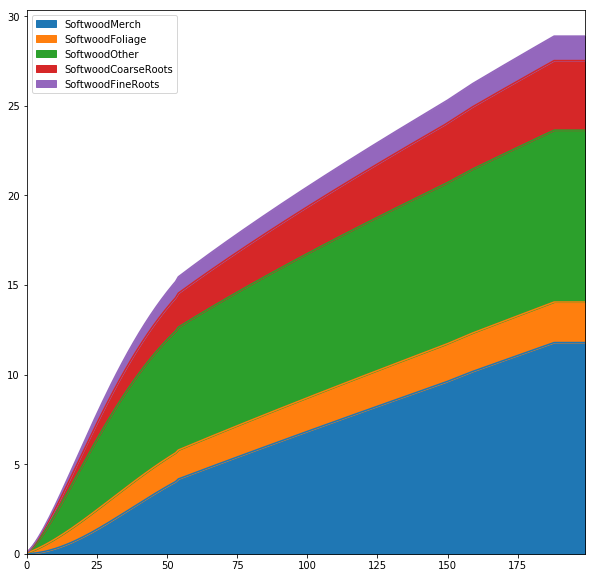

In [9]:
result \
    [['SoftwoodMerch','SoftwoodFoliage','SoftwoodOther','SoftwoodCoarseRoots','SoftwoodFineRoots']] \
    .plot(figsize=(10,10), kind="area")